Testing l1 regularization with strength 0.0001
Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 27s 5s/step - loss: 8690.1973 - accuracy: 0.3812 - val_loss: 8.0207 - val_accuracy: 0.2188
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 8.2493 - accuracy: 0.3766 - val_loss: 9.2961 - val_accuracy: 0.5312
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 9.9533 - accuracy: 0.4610 - val_loss: 10.6358 - val_accuracy: 0.3750
Epoch 4/10
5/5 [==============================] - 26s 5s/step - loss: 10.9712 - accuracy: 0.4688 - val_loss: 11.2935 - val_accuracy: 0.5312
Epoch 5/10
5/5 [==============================] - 25s 5s/step - loss: 11.5626 - accuracy: 0.4675 - val_loss: 11.7565 - val_accuracy: 0.4375
Epoch 6/10
5/5 [==============================] - 24s 5s/step - loss: 11.8779 - accuracy: 0.5000 - val_loss: 12.0167 - val_accuracy: 0.5938
Epoch 7/10
5/5 [==================

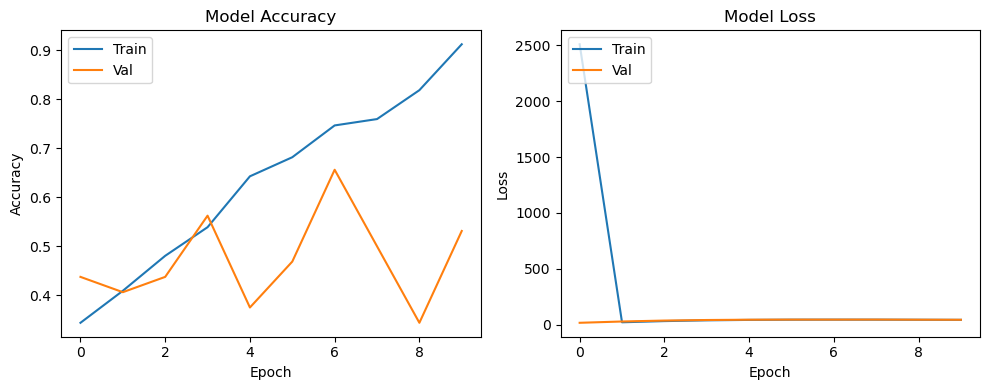

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.regularizers as regularizers

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Define regularization options and strengths
regularization_types = ['l1', 'l2']
regularization_strengths = [0.0001, 0.001, 0.01, 0.1]

best_val_accuracy = 0
best_reg_type = None
best_reg_strength = None
best_model = None

for reg_type in regularization_types:
    for reg_strength in regularization_strengths:
        print(f"Testing {reg_type} regularization with strength {reg_strength}")

        # Reset the model
        tf.keras.backend.clear_session()
        model = models.Sequential()

        # Add layers to the model
        model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())

        # Apply the regularization to the dense layer
        if reg_type == 'l1':
            reg = regularizers.l1(l=reg_strength)
        elif reg_type == 'l2':
            reg = regularizers.l2(l=reg_strength)
        
        model.add(layers.Dense(units=32, activation='relu', kernel_regularizer=reg))
        model.add(layers.Dense(num_classes, activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Define directory paths for data generators
        train_dir = os.path.join(dataset_folder, 'train')
        validation_dir = os.path.join(dataset_folder, 'validation')

        # Setup data generators
        train_datagen = ImageDataGenerator()
        validation_datagen = ImageDataGenerator()

        batch_size = 32
        target_size = (512, 512)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=target_size,
            batch_size=batch_size,
            color_mode='rgb',
            class_mode='categorical')

        validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=target_size,
            batch_size=batch_size,
            color_mode='rgb',
            class_mode='categorical')

        # Fit the model
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=10,  
            verbose=1  # Set verbose to 1 to see the training progress
        )

        # Check if this is the best model so far based on validation accuracy
        max_val_acc = max(history.history['val_accuracy'])
        if max_val_acc > best_val_accuracy:
            best_val_accuracy = max_val_acc
            best_reg_type = reg_type
            best_reg_strength = reg_strength
            best_model = model  # Save the model as the best model

# After finding the best regularization settings
print(f"Best regularization type: {best_reg_type} with strength {best_reg_strength} and validation accuracy {best_val_accuracy}")

# Optionally, save the best model
# best_model.save('path_to_my_best_model.h5')

# Plot training and validation accuracy and loss for the best model
plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()